## Machine preparation

In [ ]:
from qiskit.ml.datasets import *
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
RANDOM_STATE = 37
n = 4 # number of qubits
class_labels = ['Iris-setosa', 'Iris-versicolor']

In [ ]:
def normalizeData(DATA_PATH = "iris.data"):
    """
    Normalizes the data
    """
    # Reads the data
    data = pd.read_csv(DATA_PATH)
    data = shuffle(data, random_state=RANDOM_STATE)
    
    # remove third type of flower
    data = data[data["class"] != "Iris-virginica"]
    
    # Split into data and result
    X, Y = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values, data['class'].values
    
    # normalize the data
    X = normalize(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

In [ ]:
X_train, X_test, Y_train, Y_test = normalizeData()
print(X_train)

In [ ]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.draw(output='mpl', filename="overallcircuit.png")

In [ ]:

def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters

In [ ]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [ ]:
def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
    class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

In [ ]:
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
        probs = []
    for qc in qc_list:
        counts = qc.to_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

In [ ]:
def mse_cost(probs, expected_label):
    p = probs.get(expected_label)
    actual, pred = np.array(1), np.array(p)
    return np.square(np.subtract(actual,pred)).mean()

In [ ]:

cost_list = []
def cost_function(X, Y, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    for label in Y:
#         print(label)
        if label == 'Iris-setosa':
            training_labels += [class_labels[0]]
        elif label == 'Iris-versicolor':
            training_labels += [class_labels[1]]
    print(params)
    probs = classify(training_samples, params, class_labels)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
#         print(i)
#         print(prob)
#         print(training_labels)
#         print(training_labels[i])
        cost += mse_cost(prob, training_labels[i])
    cost /= len(training_samples)
    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    # return objective value
    cost_list.append(cost)
    return [cost]

In [ ]:

cost_list = []
optimizer = ADAM(maxiter=100, )

# define objective function for training
objective_function = lambda params: cost_function(X_train, Y_train, class_labels, params, print_value=True)
# randomly initialize the parameters
np.random.seed(RANDOM_STATE)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

In [ ]:

fig = plt.figure()
plt.plot(range(0,901,1), cost_list)
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.title("ADAM Cost value against steps")
plt.show()
fig.savefig('../../Output/Figures/costvssteps.jpeg')

In [ ]:
def test_model(X, Y, class_labels, params):
    accuracy = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    probs = classify(training_samples, params, class_labels)
    for i, prob in enumerate(probs):
        if (prob.get('Iris-setosa') >= prob.get('Iris-versicolor')) and (Y_test[i] == 0):
            accuracy += 1
        elif (prob.get('Iris-versicolor') >= prob.get('Iris-setosa')) and (Y_test[i] == 1):
            accuracy += 1
    accuracy /= len(Y_test)
    print("Test accuracy: {}\n".format(accuracy))

In [ ]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance

In [ ]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# we set shots to 10 as this will determine the number of samples later on.
qi_qasm = QuantumInstance(Aer.get_backend('aer_simulator'), shots=10)

In [ ]:
num_qubits = 4

In [ ]:
# specify the feature map
fm = ZZFeatureMap(num_qubits, reps=2)
fm.draw(output='mpl')

In [ ]:
# specify the ansatz
ansatz = RealAmplitudes(num_qubits, reps=1)
ansatz.draw(output='mpl')

In [ ]:
# specify the observable
observable = PauliSumOp.from_list([('Z'*num_qubits, 1)])
print(observable)

In [ ]:
# define two layer QNN
qnn3 = TwoLayerQNN(num_qubits,
                   feature_map=fm,
                   ansatz=ansatz,
                   observable=observable, quantum_instance=qi_sv)

In [ ]:
# define (random) input and weights
input3 = np.random.rand(qnn3.num_inputs)
weights3 = np.random.rand(qnn3.num_weights)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

In [ ]:
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

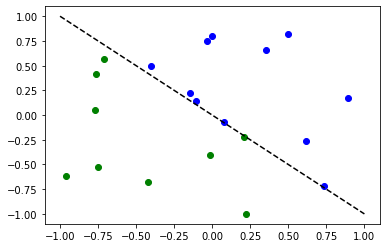

[[ 0.35467029  0.6575292 ]
 [ 0.8932122   0.17129725]
 [ 0.22382127 -0.99840926]
 [ 0.61305702 -0.26062516]
 [ 0.07422406 -0.07011414]
 [-0.10384371  0.14335466]
 [-0.76948391  0.05259415]
 [-0.00122952  0.80063792]
 [ 0.73700827 -0.71803339]
 [ 0.21080489 -0.21849291]
 [-0.14430536  0.22444962]
 [-0.42071168 -0.67499733]
 [-0.71072595  0.56958122]
 [ 0.49800825  0.82397387]
 [-0.75212601 -0.52530416]
 [-0.76093866  0.4117477 ]
 [-0.96025838 -0.62081575]
 [-0.40289457  0.49804943]
 [-0.03294083  0.75129413]
 [-0.01552392 -0.40118872]]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [12]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()
print(X)
print(y_one_hot)

In [ ]:
# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [ ]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X[0, :], np.random.rand(opflow_qnn.num_weights))

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA(), callback=callback_graph)

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X, y)

In [ ]:
# evaluate data points
y_predict = opflow_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

In [2]:
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

In [3]:
RANDOM_STATE = 37
num_inputs = 4 # number of qubits
class_labels = ['Iris-setosa', 'Iris-versicolor']

In [4]:
def normalizeData(DATA_PATH = "iris.data"):
    """
    Normalizes the data
    """
    # Reads the data
    data = pd.read_csv(DATA_PATH)
    data = shuffle(data, random_state=RANDOM_STATE)
    
    # remove third type of flower
    data = data[data["class"] != "Iris-virginica"]
    
    data['class'] = data['class'].replace(["Iris-setosa"],-1)
    data['class'] = data['class'].replace(["Iris-versicolor"],1)
    
    # Split into data and result
    X, Y = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values, data['class'].values
    
    # normalize the data
    X = normalize(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

In [5]:
X_train, X_test, Y_train, Y_test = normalizeData()
print(X_train)
print(Y_train)

[[0.74714194 0.33960997 0.54337595 0.17659719]
 [0.79524064 0.54144043 0.27072022 0.03384003]
 [0.81228363 0.5361072  0.22743942 0.03249135]
 [0.80779568 0.53853046 0.23758697 0.03167826]
 [0.81803119 0.51752994 0.25041771 0.01669451]
 [0.73239618 0.38547167 0.53966034 0.15418867]
 [0.77381111 0.59732787 0.2036345  0.05430253]
 [0.81609427 0.5336001  0.21971769 0.03138824]
 [0.8173379  0.51462016 0.25731008 0.03027177]
 [0.78609038 0.57170209 0.23225397 0.03573138]
 [0.76741698 0.34773582 0.51560829 0.15588157]
 [0.76986879 0.35413965 0.5081134  0.15397376]
 [0.786991   0.55745196 0.26233033 0.03279129]
 [0.78591858 0.57017622 0.23115252 0.06164067]
 [0.80846584 0.52213419 0.26948861 0.03368608]
 [0.80218492 0.54548574 0.24065548 0.0320874 ]
 [0.79837025 0.55735281 0.22595384 0.03012718]
 [0.82699754 0.52627116 0.19547215 0.03007264]
 [0.76785726 0.34902603 0.51190484 0.16287881]
 [0.790965   0.5694948  0.2214702  0.0316386 ]
 [0.82210585 0.51381615 0.23978087 0.05138162]
 [0.73446047 

In [6]:
# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [7]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X[0, :], np.random.rand(opflow_qnn.num_weights))

NameError: name 'X' is not defined

In [8]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [9]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA(), callback=callback_graph)

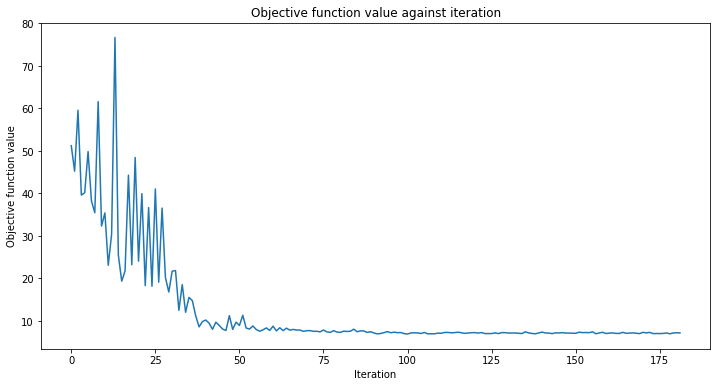

1.0

In [10]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train, Y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_train, Y_train)
opflow_classifier.score(X_test, Y_test)

In [ ]:
# evaluate data points
y_predict = opflow_classifier.predict(X_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, Y_test, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        print("wrong")
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()